In [5]:
import numpy as np
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [6]:
# {not run}
# handling the dataset
from sklearn.model_selection import train_test_split
import pandas as pd

ds = pd.read_csv('data.csv')

# now define the subset to train ARIMA and the testing (serving) part
train_ds, test_ds = train_test_split(ds, test_size= 0.4, shuffle=False)  # not shufflig to maintainn sequential order of evets  xd
test_ds.to_csv('test.csv', index = False)       # disable index tags (col)
train_ds.to_csv('train.csv', index = False)

C:\Users\olapu\AppData\Local\Temp/ipykernel_11996/1060357061.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Day sin'] = np.sin(time_perio * (2 * np.pi / day))
C:\Users\olapu\AppData\Local\Temp/ipykernel_11996/1060357061.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Day cos'] = np.cos(time_perio * (2 * np.pi / day))


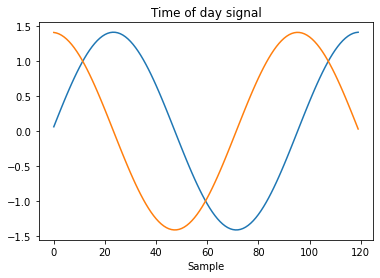

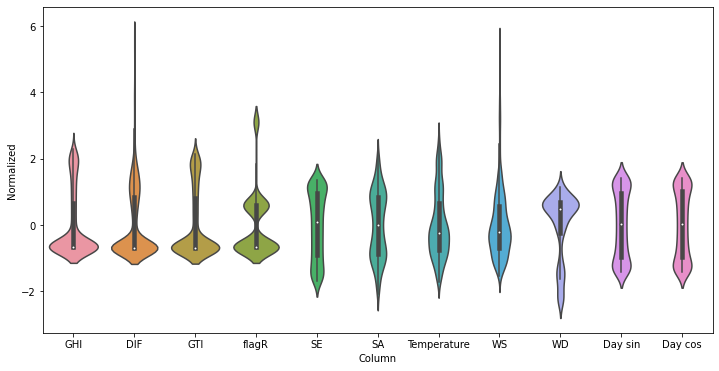

In [7]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models
# create a DNN multishot model then serve it (use model.predict([BATCH]))
# use the necessary features to achieve 'decent' performance

def prepare_ds(dataframe):
    
    # convert date_time to timestamp to use a periodic function instead of numerics timestamps
    date_time = dataframe['Date_Time']
    
    time_perio = date_time.map(pd.Timestamp.timestamp) # in seconds
    # converting tiemstamp to sin / cos variables:
    # periods:
    day = 24*60*60
    year = day*(365.2425) # xd

    # adding the sin/cos features to the dataset:
    dataframe['Day sin'] = np.sin(time_perio * (2 * np.pi / day))
    dataframe['Day cos'] = np.cos(time_perio * (2 * np.pi / day))

    dataframe.pop('Date_Time')
    # Normalizin columns
    promedio = dataframe.mean()
    desv_est = dataframe.std()

    # run ONCE after loading the data (ONLY ONCE)
    dataframe = (dataframe - promedio) / desv_est
    return dataframe


train_df= pd.read_csv("train.csv", parse_dates=[['Date', 'Time']], dayfirst= True) # F**k
# train_df = train_df[['Date_Time', 'Temperature']]


train_ds, val_ds = train_test_split(train_df, test_size=0.3, shuffle= False)

# train_df  ?
train_ds = prepare_ds(train_ds)


# val_df    ?
val_ds = prepare_ds(val_ds)

# test_df   ?
test_df= pd.read_csv("test.csv", parse_dates=[['Date', 'Time']], dayfirst= True) # F**k
# test_df = test_df[['Date_Time', 'Temperature']]
test_ds = prepare_ds(test_df)



plt.plot(np.array(train_ds['Day sin'][:120]))
plt.plot(np.array(train_ds['Day cos'][:120]))
plt.xlabel('Sample')
plt.title('Time of day signal')


to_plot = train_ds.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = to_plot)
# _ = ax.set_xticklabels(to_plot.keys(), rotation = 90)



In [8]:

# elper fctios:


class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_ds, val_df=val_ds, test_df=test_ds,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def plot(self, model=None, plot_col='Temperature', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        predictions = predictions*
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  print(self.test_df.head())
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Temperature'])
                     
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_ds[:w2.total_window_size]),
                           np.array(train_ds[100:100+w2.total_window_size]),
                           np.array(train_ds[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

window = WindowGenerator(
    input_width=10, label_width=10, shift=1)

All shapes are: (batch, time, features)
Window shape: (3, 7, 11)
Inputs shape: (3, 6, 11)
Labels shape: (3, 1, 1)


14/14 [==============================] - 0s 3ms/step - loss: 0.4589 - mean_absolute_error: 0.4887
        GHI       DIF       GTI     flagR        SE        SA  Temperature  \
0  1.340618  0.984313  1.435334  0.526772  1.112588  0.379508     2.082687   
1  1.195322  0.830762  1.337859  0.526772  1.063214  0.417738     1.998687   
2  0.991907  0.721083  1.168903  0.526772  1.009845  0.454522     1.942686   
3  0.747810  0.677211  0.947959  0.526772  0.953337  0.489858     1.858686   
4  0.521148  0.611404  0.736764  0.526772  0.893689  0.523868     1.774685   

         WS        WD   Day sin   Day cos  
0  0.622506  0.963644 -0.800882 -1.153883  
1  0.622506  0.995002 -0.873480 -1.096602  
2  0.622506  1.026361 -0.942196 -1.034670  
3  0.729444  1.049880 -1.006737 -0.968352  
4  0.622506  1.065559 -1.066825 -0.897932  
INFO:tensorflow:Assets written to: modelo_1\assets


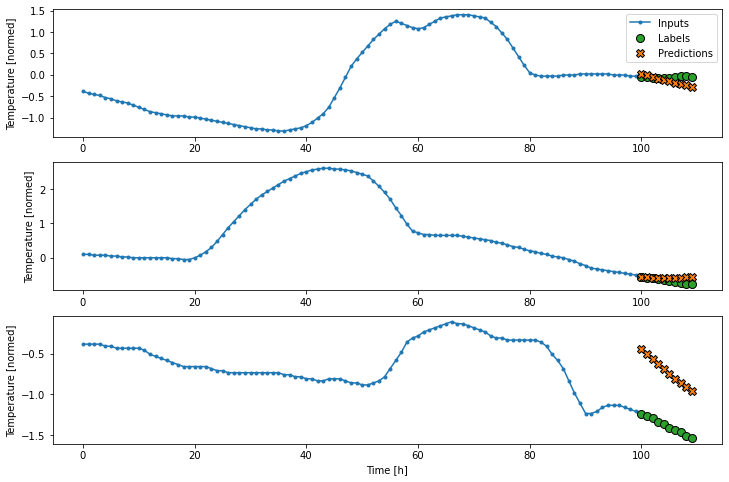

In [12]:
#defie de odel

OUT_STEPS = 10
multi_window = WindowGenerator(input_width=100,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

num_features = train_ds.shape[1]

model = tf.keras.Sequential([
        # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

patience = 2
MAX_EPOCHS = 30

# copile d fit de odel
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])


IPython.display.clear_output()
val_performance = model.evaluate(multi_window.val)
performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

model.save('modelo_1')